<a href="https://colab.research.google.com/github/achmadbadri/UjiCoba/blob/main/Final_Code_4_16_2021_Dengan_Aktivasi_Relu_dan_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650

In [1]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style
from google.colab import files
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2018 data to train our model
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2018,12,31)
df = web.DataReader("ANTM.JK", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2018,11,13)
end = datetime.datetime(2019,12,31)
test_df = web.DataReader("ANTM.JK", 'yahoo', start, end) 
print(df.shape)
print(test_df.shape)

(1251, 6)
(292, 6)


In [3]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].to_numpy()
print(train_data.shape) # 1258 


# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1251,)


In [4]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)


# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1215, 36, 1)
X_train:
[[872.93395996]
 [840.60314941]
 [812.31359863]
 [812.31359863]
 [816.35498047]
 [812.31359863]
 [792.10675049]
 [800.18951416]
 [800.18951416]
 [824.43762207]
 [812.31359863]
 [832.52032471]
 [872.93395996]
 [864.85125732]
 [844.64447021]
 [840.60314941]
 [816.35498047]
 [812.31359863]
 [816.35498047]
 [832.52032471]
 [824.43762207]
 [812.31359863]
 [808.2722168 ]
 [808.2722168 ]
 [816.35498047]
 [820.39630127]
 [840.60314941]
 [836.56170654]
 [820.39630127]
 [820.39630127]
 [836.56170654]
 [856.76855469]
 [856.76855469]
 [844.64447021]
 [852.72723389]
 [848.68585205]]


y_train: [[836.56170654]]



In [27]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#model.add(Dropout(0.2))

model.add(LSTM(units = 64, return_sequences = False))
#model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 16,  activation='relu'))
model.add(Dense(units = 1, activation= 'linear'))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
85/85 [==============================] - 7s 53ms/step - loss: 0.0694 - val_loss: 0.0035
Epoch 2/20
85/85 [==============================] - 4s 43ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 3/20
85/85 [==============================] - 4s 43ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/20
85/85 [==============================] - 4s 45ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 5/20
85/85 [==============================] - 4s 44ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 6/20
85/85 [==============================] - 4s 45ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/20
85/85 [==============================] - 4s 44ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 8/20
85/85 [==============================] - 4s 44ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/20
85/85 [==============================] - 4s 44ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/20
85/85 [==============================] - 4s 45ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 11/

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 36, 128)           66560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 117,025
Trainable params: 117,025
Non-trainable params: 0
_________________________________________________________________


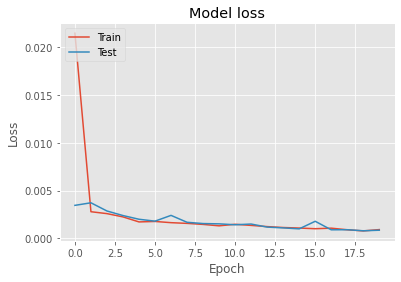

In [29]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)


In [31]:
predicted_y = pd.DataFrame(predicted_y)
org_y = pd.DataFrame(org_y)
describe = pd.DataFrame()
describe['True Price'] = org_y[0]
describe['Prediction'] = predicted_y[0]
describe['difference'] = org_y[0] - predicted_y[0]
describe['MAPE (%)'] = abs(describe['difference']/org_y[0]*100)
describe.describe()

,True Price,Prediction,difference,MAPE (%)
count,256.000000,256.000000,256.000000,256.000000
mean,885.951885,894.103271,-8.151097,2.368719
std,109.317800,109.735413,25.972037,1.858978
min,662.090576,675.109497,-70.227234,0.006736
25%,810.319885,818.134430,-23.285522,0.930175
50%,872.602203,879.433380,-9.178955,1.875413
75%,968.612732,972.622574,4.574371,3.434863
max,1156.188110,1123.322876,89.078613,8.401148


In [32]:
describe.head(10)

,True Price,Prediction,difference,MAPE (%)
0,719.471497,752.009705,-32.538208,4.522515
1,729.194092,739.088440,-9.894348,1.356888
2,738.916626,735.511292,3.405334,0.460855
3,748.639221,740.647949,7.991272,1.067440
4,738.916626,750.222046,-11.305420,1.529999
5,758.361755,750.802307,7.559448,0.996813
6,768.084351,759.443726,8.640625,1.124958
7,768.084351,770.192627,-2.108276,0.274485
8,758.361755,775.632446,-17.270691,2.277368
9,797.252136,771.690491,25.561646,3.206219


In [33]:
a = np.array(describe['True Price'])
b = np.array(describe['Prediction'])

# MSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE: %.2f" % mean_squared_error(a, b))

# The RMSE
print("RMSE: %.2f" % mean_squared_error(a, b, squared=False))

# The MAE
print("MAE: %.2f" % mean_absolute_error(a, b))

#Mean Absolute Percentange Error
c = (np.mean(np.abs((a - b) / a))) * 100
print('MAPE : ', c)

# Explained variance score: 1 is perfect prediction
from sklearn.metrics import r2_score
print('R2 score: %.2f' % r2_score(a, b))


MSE: 738.35
RMSE: 27.17
MAE: 21.14
MAPE :  2.3687188683807356
R2 score: 0.94


In [34]:
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_test, y_test))

38/38 [==============================] - 1s 20ms/step - loss: 7.9339e-04
0.0007933854358270764
8/8 [==============================] - 1s 20ms/step - loss: 0.0013
0.0012903906172141433


In [35]:
print(model.metrics_names)

['loss']


In [36]:
graph  = test_df.drop(test_df.index[0:36])
graph.reset_index(inplace=True)
graph.rename(columns = {'index':'Date'})
graph = graph.drop(columns=['High','Low','Open','Volume','Close'])
graph['Predict_Value'] = predicted_y[0]
graph.head()
graph.set_index('Date', inplace=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

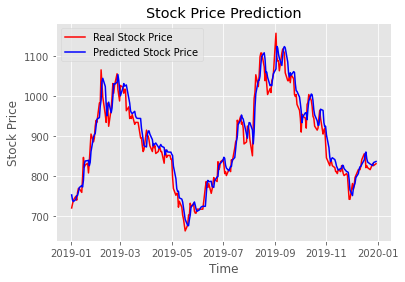

In [37]:
# plot the results 
plt.plot(graph['Adj Close'], color = 'red', label = 'Real Stock Price')
plt.plot(graph['Predict_Value'], color = 'blue', label = 'Predicted Stock Price')
#plt.plot(df['Adj Close'], color = 'black', label = 'Past Stock')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Stock Price SVR LSTM 1.png')
files.download("Stock Price SVR LSTM 1.png")
plt.show()

In [38]:
final  = test_df.drop(test_df.index[0:36])
final.reset_index(inplace=True)
final.rename(columns = {'index':'Date'})
final = final.drop(columns=['High','Low','Open','Volume','Close'])
final['Predict_Value'] = predicted_y[0]
final['Selisih'] = final['Adj Close'] - final['Predict_Value']
final['Lost/Risk (%)'] = abs((final['Adj Close'] - final['Predict_Value'])/final['Predict_Value']*100)
final = final.drop(columns=['Adj Close'])

In [39]:
percent = test_df.drop(test_df.index[0:35])
percent = percent.drop(test_df.index[-1])
percent.reset_index(inplace=True)
percent.rename(columns = {'index':'Date'}) 
percent = percent.drop(columns=['High','Low','Open','Volume','Close'])
percent['Next Day'] = predicted_y
percent['Plus or Minus']= percent['Adj Close'] - percent['Next Day']
percent['Next Day (%)']= abs(((percent['Adj Close'] - percent['Next Day'])/percent['Adj Close'])*100)

In [40]:
True_Next_Day = test_df.drop(test_df.index[0:35])
True_Next_Day = True_Next_Day.drop(test_df.index[-1])
True_Next_Day.reset_index(inplace=True)
True_Next_Day.rename(columns = {'index':'Date'}) 
True_Next_Day = True_Next_Day.drop(columns=['High','Low','Open','Volume','Close'])
True_Next_Day['True Next Day'] = org_y
True_Next_Day['True Plus or Minus']= (True_Next_Day['Adj Close'] - True_Next_Day['True Next Day'])
True_Next_Day['True Next Day (%)']= abs(((True_Next_Day['Adj Close'] - True_Next_Day['True Next Day'])/True_Next_Day['Adj Close'])*100)
True_Next_Day = True_Next_Day.drop(columns=['Adj Close','True Next Day'])

In [41]:
Concating = percent.merge(final, how='outer', on='Date')
Concating = Concating.merge(True_Next_Day, how='outer', on='Date')
#Concating.set_index('Date', inplace=True)
Final_Predict = Concating.copy()
Final_Predict['Harga Saham Hari ini'] = Concating['Adj Close']
Final_Predict['Prediksi Besok'] = Concating['Plus or Minus']
Final_Predict['Harga Besok Sebenarnya'] = Concating['True Plus or Minus']
Final_Predict['Prediksi Besok (%)'] = (Concating['Next Day (%)'])
Final_Predict['Harga Besok Sebenarnya (%)'] = Concating['True Next Day (%)']
Final_Predict['Selisih Prediksi'] = (Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok'])
Final_Predict['Risk/MAPE(%)'] = abs(((Final_Predict['Harga Besok Sebenarnya'] - Final_Predict['Prediksi Besok'])/Final_Predict['Harga Besok Sebenarnya'])*100)
Final_Predict['Risk/MAPE(%)'] = round(Final_Predict['Risk/MAPE(%)'], 2)
Final_Predict = Final_Predict.drop(columns=['Adj Close', 'Next Day', 'Plus or Minus', 'Next Day (%)',
                                            'Predict_Value', 'Selisih', 'Lost/Risk (%)', 'True Plus or Minus',
                                            'True Next Day (%)'])
Final_Predict = Final_Predict.replace(0, np.nan)
Final_Predict = Final_Predict.dropna()
Final_Predict.set_index('Date', inplace=True)
Final_Predict.shape

(236, 7)

In [42]:
Final_Predict.head()

,Harga Saham Hari ini,Prediksi Besok,Harga Besok Sebenarnya,Prediksi Besok (%),Harga Besok Sebenarnya (%),Selisih Prediksi,Risk/MAPE(%)
Date,,,,,,,
2019-01-01,743.777893,-8.231812,24.306396,1.106757,3.267964,32.538208,133.87
2019-01-02,719.471497,-19.616943,-9.722595,2.726577,1.351352,9.894348,101.77
2019-01-03,729.194092,-6.317200,-9.722534,0.866326,1.333326,-3.405334,35.03
2019-01-04,738.916626,-1.731323,-9.722595,0.234306,1.315791,-7.991272,82.19
2019-01-07,748.639221,-1.582825,9.722595,0.211427,1.298702,11.305420,116.28


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

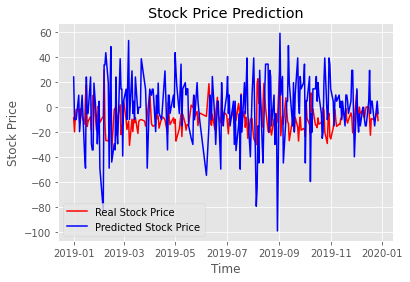

In [43]:
# plot the results 
plt.plot(Final_Predict['Prediksi Besok'], color = 'red', label = 'Real Stock Price')
plt.plot(Final_Predict['Harga Besok Sebenarnya'], color = 'blue', label = 'Predicted Stock Price')
#plt.plot(Final_Predict['Risk/MAPE(%)'], color = 'black', label = 'RISK/MAPE(%)')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('Stock Price SVR LSTM 1.png')
files.download("Stock Price SVR LSTM 1.png")
plt.show()

In [44]:
#### Mencari Data STAT MODEL

In [45]:
a = X_test
a = np.reshape(a, (-1, 36))
a = scaler.inverse_transform(a)
a = pd.DataFrame(a)

In [46]:
b = y_test
#b = np.reshape(b, (-1, 36))
b = scaler.inverse_transform(b)
b = pd.DataFrame(b)

In [47]:
#OLS Model
import statsmodels.api as sm
X = a
Y = b
X = sm.add_constant(X)
model_ols = sm.OLS(Y,X)
results = model_ols.fit()

In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     143.6
Date:                Fri, 16 Apr 2021   Prob (F-statistic):          1.18e-132
Time:                        00:35:27   Log-Likelihood:                -1154.5
No. Observations:                 256   AIC:                             2383.
Df Residuals:                     219   BIC:                             2514.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9509     16.051      3.112      0.002      18.317      81.585
0              0.0584      0.063      0.920      0.358      -0.067       0.183
1             -0.0659      0.087     -0.755      0.451      -0.238       0.106
2              0.0307      0.087      0.351      0.726      -0.141       0.203
3             -0.0725      0.087     -0.830      0.407      -0.244       0.100
4             -0.0218      0.087     -0.250      0.803      -0.194       0.150
5              0.0178      0.088      0.202      0.840      -0.155       0.191
6              0.0315      0.088      0.357      0.721      -0.142       0.205
7             -0.0219      0.089     -0.247      0.805      -0.197       0.153
8             -0.0365      0.089     -0.409      0.683      -0.212       0.139
9              0.2115      0.088      2.394      0.018       0.037       0.386
10            -0.1701      0.088     -1.938      0.054      -0.343       0.003
11            -0.0129      0.088     -0.147      0.884      -0.186       0.160
12             0.0236      0.088      0.269      0.788      -0.150       0.197
13             0.0549      0.088      0.625      0.533      -0.118       0.228
14            -0.1624      0.090     -1.807      0.072      -0.339       0.015
15             0.1312      0.093      1.414      0.159      -0.052       0.314
16            -0.1052      0.093     -1.128      0.260      -0.289       0.079
17            -0.0610      0.093     -0.654      0.514      -0.245       0.123
18             0.0984      0.093      1.060      0.290      -0.085       0.281
19             0.0740      0.093      0.798      0.426      -0.109       0.257
20            -0.0746      0.093     -0.801      0.424      -0.258       0.109
21            -0.0350      0.093     -0.374      0.709      -0.219       0.149
22             0.0518      0.094      0.551      0.582      -0.133       0.237
23             0.0137      0.094      0.146      0.884      -0.172       0.199
24             0.0301      0.094      0.319      0.750      -0.156       0.216
25            -0.0402      0.095     -0.425      0.672      -0.227       0.146
26             0.1439      0.095      1.514      0.132      -0.043       0.331
27            -0.1967      0.095     -2.065      0.040      -0.385      -0.009
28             0.1757      0.095      1.858      0.065      -0.011       0.362
29            -0.0905      0.094     -0.960      0.338      -0.276       0.095
30            -0.0891      0.094     -0.948      0.344      -0.274       0.096
31             0.1501      0.093      1.607      0.110      -0.034       0.334
32            -0.0451      0.093     -0.483      0.630      -0.229       0.139
33             0.0371      0.093      0.397      0.691      -0.147       0.221
34            -0.0534      0.093     -0.572      0.568      -0.238       0.131
35